# Задача разбора мусорки*
*Когда все документы берутся как документы из одной кучи

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from dataset import DatasetTextExtractor
from dataset import add_pred_target_name

from vectorizers import Tfidf, CountVec

from sklearn.decomposition import PCA

from vizualization import plot_cluster, plot_confusion_matrix

random_state = 42

## Load data

In [2]:
# загрузим и сохраним датасет
from pathlib import Path

root_path = Path('./')
dataset_raw_path = root_path.joinpath('dataset')
dataset_save_path = root_path.joinpath('saved_dataset.pickle')

dl = DatasetTextExtractor()
if dataset_save_path.is_file():
    dataset = dl.load(dataset_save_path)
else:
    dataset = dl.read(dataset_raw_path)
    dl.save(dataset_save_path)

## Vectorize

In [3]:
vectors_path = root_path.joinpath('vectors')
vectors_path.mkdir(parents=True, exist_ok=True)

# tfidf
tf_idf_vectors_save_path = vectors_path.joinpath('tfidf.pickle')

tfidf_vectorizer = Tfidf()
if tf_idf_vectors_save_path.is_file():
    tfidf_vectors = tfidf_vectorizer.load(tf_idf_vectors_save_path)
else:
    tfidf_vectors = tfidf_vectorizer.fit_transform(dataset['text'].values)
    tfidf_vectorizer.save(tf_idf_vectors_save_path)

# count
count_vectors_save_path = vectors_path.joinpath('count.pickle')

count_vectorizer = CountVec()
if count_vectors_save_path.is_file():
    count_vectors = count_vectorizer.load(count_vectors_save_path)
else:
    count_vectors = count_vectorizer.fit_transform(dataset['text'].values)
    count_vectorizer.save(count_vectors_save_path)

## Кластеризация

In [4]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN
import hdbscan

In [5]:
def clusterization(estimator, X, dataset, key):
    """
    estimator - кластеризатор
    X - вектора
    dataset - исходный датасет который обновляем полученными данными
    key - уникальная строка для метода веторизации, кластеризатор, по ней будут формировать в dataset названия столбцов
    
    
    Обучить кластеризатор
    Вывести метрики
    Добавить в исходный датасет предсказанные кластера и названия кластеров
    Визуализировать кластер
    Вывести 
    """
    
    # train
    estimator.fit(X)
    labels = estimator.labels_
    
    # metrics     
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(estimator)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    if n_clusters_:
        print("Silhouette Coefficient on X: %0.3f" % metrics.silhouette_score(X, labels))

        predicted_target_column_name = f'{key}_target'
        predicted_target_name_column_name = f'{predicted_target_column_name}_name'
        
        dataset[predicted_target_column_name] = labels


        # reduce data
        pca_2D = PCA(n_components=2, random_state=random_state)
        reduced_pca_2D = pca_2D.fit_transform(X.toarray())
        
        print("Silhouette Coefficient on reduced 2D tfidf: %0.3f" % metrics.silhouette_score(reduced_pca_2D, labels))
        
        # cluster visualization with cluster ID
        plot_cluster(features=reduced_pca_2D, y_pred=labels, y_labels=dataset[['file_name']])
    
    
        add_pred_target_name(dataset, predicted_target_column_name, 'target_name', predicted_target_name_column_name)

        # plot confusion matrix 
        y_true = dataset.target_name.values
        y_pred = dataset[predicted_target_name_column_name].values
        cm_labels = dataset.target_name.unique()

        plot_confusion_matrix(y_true, y_pred, cm_labels)

        # cluster visualization with kind names
        plot_cluster(features=reduced_pca_2D, y_pred=y_pred, y_labels=dataset[['file_name']])
    

# Кластеризация разными алгоритмами
## Первый график - распределение кластеров в кластеризации
## Второй график - эталонное распределение данных по кластерам
## Таблица - пересечение предсказанных лейблов и эталонных.
Задача: 
Сейчас минимальное количество ошибок в текущем состоянии - 52. Попробуй понизить их число в 2 раза.

### K-means

KMeans(n_clusters=5, random_state=42)
Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient on X: 0.222
Silhouette Coefficient on reduced 2D tfidf: 0.688


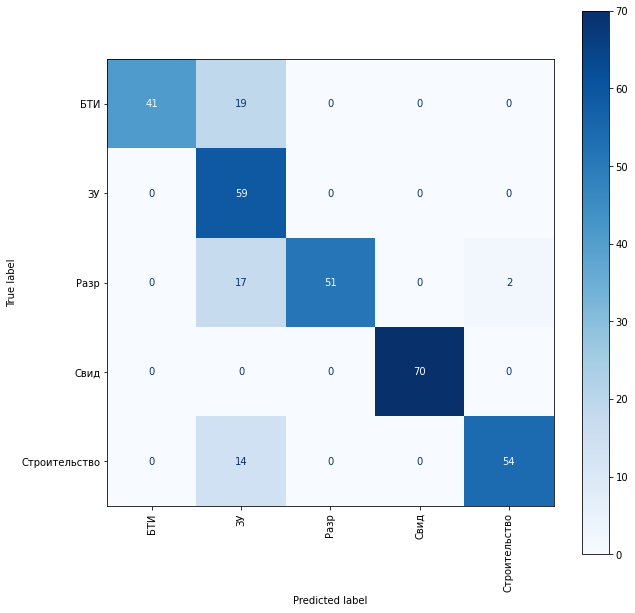

In [6]:
n_clusters = 5

estimator = KMeans(n_clusters=n_clusters, random_state=42)
clusterization(estimator, tfidf_vectors, dataset, 'kmeans_tfidf')

KMeans(n_clusters=5, random_state=42)
Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient on X: 0.222
Silhouette Coefficient on reduced 2D tfidf: 0.688


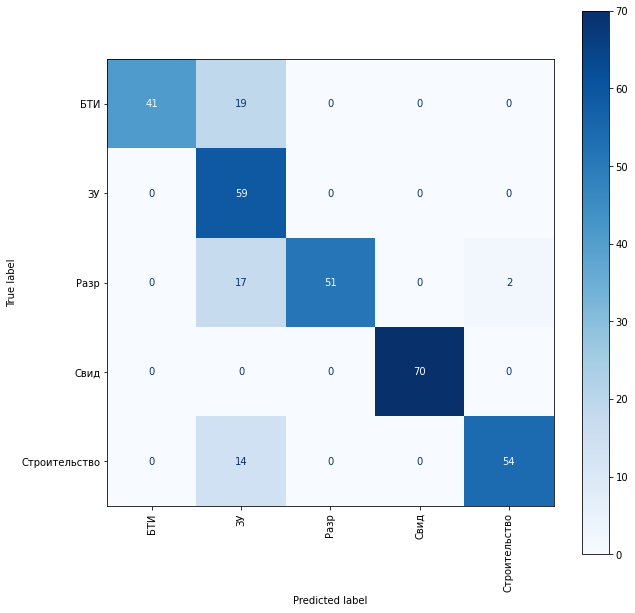

In [7]:
from sklearn import preprocessing

tfidf_vectors_normalized = preprocessing.normalize(tfidf_vectors, norm='l2')
clusterization(estimator, tfidf_vectors_normalized, dataset, 'kmeans_tfidf_normalized')

## DBSCAN

DBSCAN(eps=0.3, min_samples=10)
Estimated number of clusters: 1
Estimated number of noise points: 316
Silhouette Coefficient on X: 0.079
Silhouette Coefficient on reduced 2D tfidf: -0.263


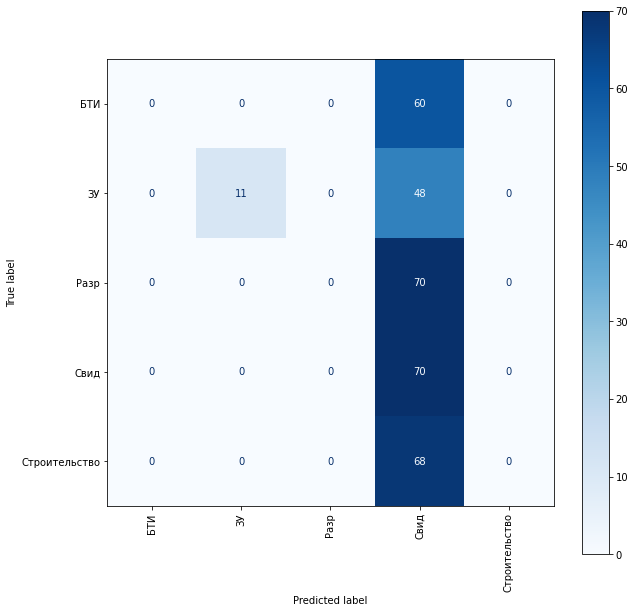

In [8]:
estimator = DBSCAN(eps=0.3, min_samples=10)
clusterization(estimator, tfidf_vectors, dataset, 'dbscan_tfidf_03_10')

DBSCAN(eps=0.3, metric='cosine', min_samples=10)
Estimated number of clusters: 7
Estimated number of noise points: 156
Silhouette Coefficient on X: 0.127
Silhouette Coefficient on reduced 2D tfidf: 0.012


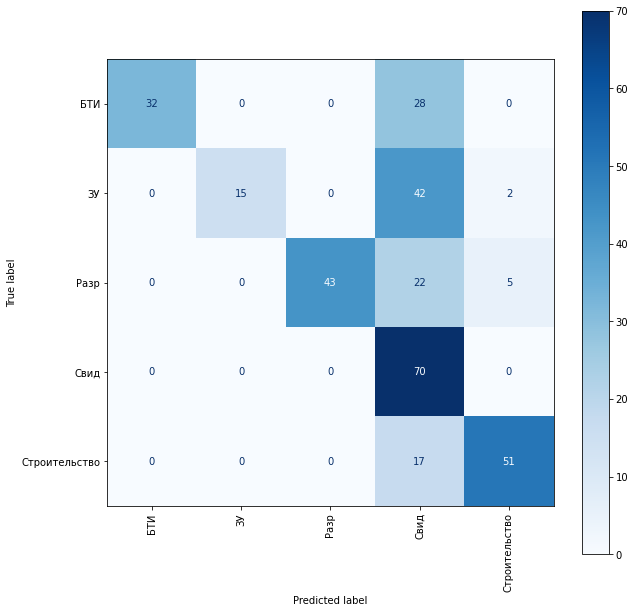

In [9]:
estimator = DBSCAN(eps=0.3, min_samples=10, metric='cosine')
clusterization(estimator, tfidf_vectors, dataset, 'dbscan_tfidf_03_10_cosine')

DBSCAN(algorithm='brute', eps=0.3, metric='cosine', min_samples=10)
Estimated number of clusters: 7
Estimated number of noise points: 156
Silhouette Coefficient on X: 0.127
Silhouette Coefficient on reduced 2D tfidf: 0.012


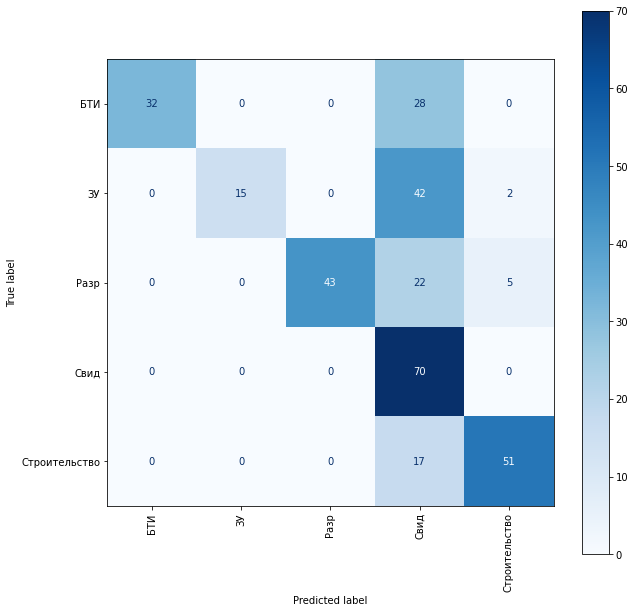

In [10]:
estimator = DBSCAN(eps=0.3, min_samples=10, metric='cosine', algorithm='brute')
clusterization(estimator, tfidf_vectors, dataset, 'dbscan_tfidf_03_10_cosine_brute')


In [11]:
estimator = DBSCAN(eps=0.9, min_samples=500, metric='cosine', algorithm='brute')
clusterization(estimator, tfidf_vectors, dataset, 'dbscan_tfidf_01_100_cosine_brute')

DBSCAN(algorithm='brute', eps=0.9, metric='cosine', min_samples=500)
Estimated number of clusters: 0
Estimated number of noise points: 327


## hdbscan

HDBSCAN()
Estimated number of clusters: 12
Estimated number of noise points: 56
Silhouette Coefficient on X: 0.082
Silhouette Coefficient on reduced 2D tfidf: 0.343


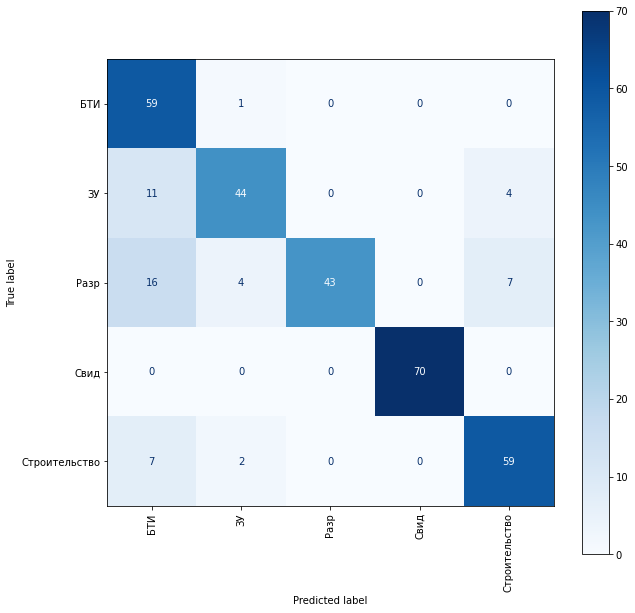

In [12]:
import hdbscan

estimator = hdbscan.HDBSCAN()
clusterization(estimator, tfidf_vectors, dataset, 'hdbscan')